In [48]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

Parte 1: Carga y Exploración Inicial de Datos

- Carga del Dataset:
    * Cargar el dataset desde Kaggle.
- Exploración Inicial:
    * Revisar la estructura del dataset.
    * Describir las variables y su distribución.
    * Identificar y documentar valores faltantes y outliers.


### Dictionary:

* Loan_ID =	Unique Loan ID
* Gender =	Male/ Female
* Married =	Applicant married (Y/N)
* Dependents =	Number of dependents
* Education =	Applicant Education (Graduate/ Under Graduate)
* Self_Employed =	Self employed (Y/N)
* ApplicantIncome =	Applicant income
* CoapplicantIncome =	Coapplicant income
* LoanAmount =	Loan amount in thousands
* Loan_Amount_Term =	Term of loan in months
* Credit_History =	credit history meets guidelines
* Property_Area =	Urban/ Semi Urban/ Rural
* Loan_Status =	Loan approved (Y/N)



In [ ]:
##Cargar los datos
ruta_archivo_train = '../ejercicios_core/data/train_loan.csv'
ruta_archivo_test = '../ejercicios_core/data/test_loan.csv'
df_train = utils.cargar_datos(ruta_archivo_train)
df_test = utils.cargar_datos(ruta_archivo_test)
print(df_train.head())
print(df_test.head())


    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [28]:
utils.exploracion_inicial(df_train)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   

Este dataset cuenta con 614 filas con 13 colunnas, de las cuales algunas columnas cuentas con valores nulos o vacios, esto pueden darse como son el caso de coapplicantincome ya que estos podrian no tener coaplicantes

In [29]:
na_df = utils.identificar_valores_faltantes(df_train)
print(na_df)
utils.verificacion_elementos_duplicados(df_train)


Valores faltantes en el dataset
                   datos sin NAs en q  Na en q  Na en %
Credit_History                    564       50     8.14
Self_Employed                     582       32     5.21
LoanAmount                        592       22     3.58
Dependents                        599       15     2.44
Loan_Amount_Term                  600       14     2.28
Gender                            601       13     2.12
Married                           611        3     0.49
Loan_ID                           614        0     0.00
Education                         614        0     0.00
ApplicantIncome                   614        0     0.00
CoapplicantIncome                 614        0     0.00
Property_Area                     614        0     0.00
Loan_Status                       614        0     0.00
Cantidad de filas duplicadas:  0


In [30]:
### Se encontraron valores faltantes en el dataset por lo que se procederan a imputar individualmente
print(df_train['Gender'].value_counts())
df_train['Gender']= df_train['Gender'].fillna(df_train['Gender'].mode()[0])

Gender
Male      489
Female    112
Name: count, dtype: int64


In [31]:
print(df_train['Married'].value_counts())
df_train['Married']= df_train['Married'].fillna(df_train['Married'].mode()[0])

Married
Yes    398
No     213
Name: count, dtype: int64


In [32]:
print(df_train['Dependents'].value_counts())
df_train['Dependents']= df_train['Dependents'].fillna(df_train['Dependents'].mode()[0])

Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64


In [33]:
print(df_train['Self_Employed'].value_counts())
df_train['Self_Employed']= df_train['Self_Employed'].fillna(df_train['Self_Employed'].mode()[0])

Self_Employed
No     500
Yes     82
Name: count, dtype: int64


In [34]:
print(df_train['LoanAmount'].value_counts())
## Se imputara por la mediana ya que es mas robusta que la media para este caso ya que no tienen una distribucion normal
df_train['LoanAmount']= df_train['LoanAmount'].fillna(df_train['LoanAmount'].median())


LoanAmount
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: count, Length: 203, dtype: int64


In [35]:
print(df_train['Loan_Amount_Term'].value_counts())
df_train['Loan_Amount_Term']= df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0])

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64


In [36]:
print(df_train['Credit_History'].value_counts())
df_train['Credit_History']= df_train['Credit_History'].fillna(df_train['Credit_History'].mode()[0])

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64


In [37]:
##Se elimina loan_id ya que no es necesario para el modelo
df_train.drop(['Loan_ID'], axis=1, inplace=True)

In [38]:
utils.identificar_valores_faltantes(df_train)

Valores faltantes en el dataset


,datos sin NAs en q,Na en q,Na en %
Gender,614,0,0.0
Married,614,0,0.0
Dependents,614,0,0.0
Education,614,0,0.0
Self_Employed,614,0,0.0
ApplicantIncome,614,0,0.0
CoapplicantIncome,614,0,0.0
LoanAmount,614,0,0.0
Loan_Amount_Term,614,0,0.0
Credit_History,614,0,0.0


Parte 2: Análisis Exploratorio de Datos (EDA)

- Análisis Estadístico Descriptivo:
    * Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
    * Analizar la distribución de las variables categóricas.
- Visualizaciones:
    * Crear histogramas y gráficos de barras para entender la distribución de las variables.
    * Crear un mapa de calor para visualizar las correlaciones entre las variables.
    * Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.
- Valores Faltantes y Outliers:
    * Detectar y tratar valores faltantes.
    * Identificar y manejar outliers.


Estadisticas del dataset
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  614.000000        614.000000   
mean       5403.459283        1621.245798  145.752443        342.410423   
std        6109.041673        2926.248369   84.107233         64.428629   
min         150.000000           0.000000    9.000000         12.000000   
25%        2877.500000           0.000000  100.250000        360.000000   
50%        3812.500000        1188.500000  128.000000        360.000000   
75%        5795.000000        2297.250000  164.750000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  
count      614.000000  
mean         0.855049  
std          0.352339  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
Medidas de tendencia central y dispersión para cada variable numérica

ApplicantInc

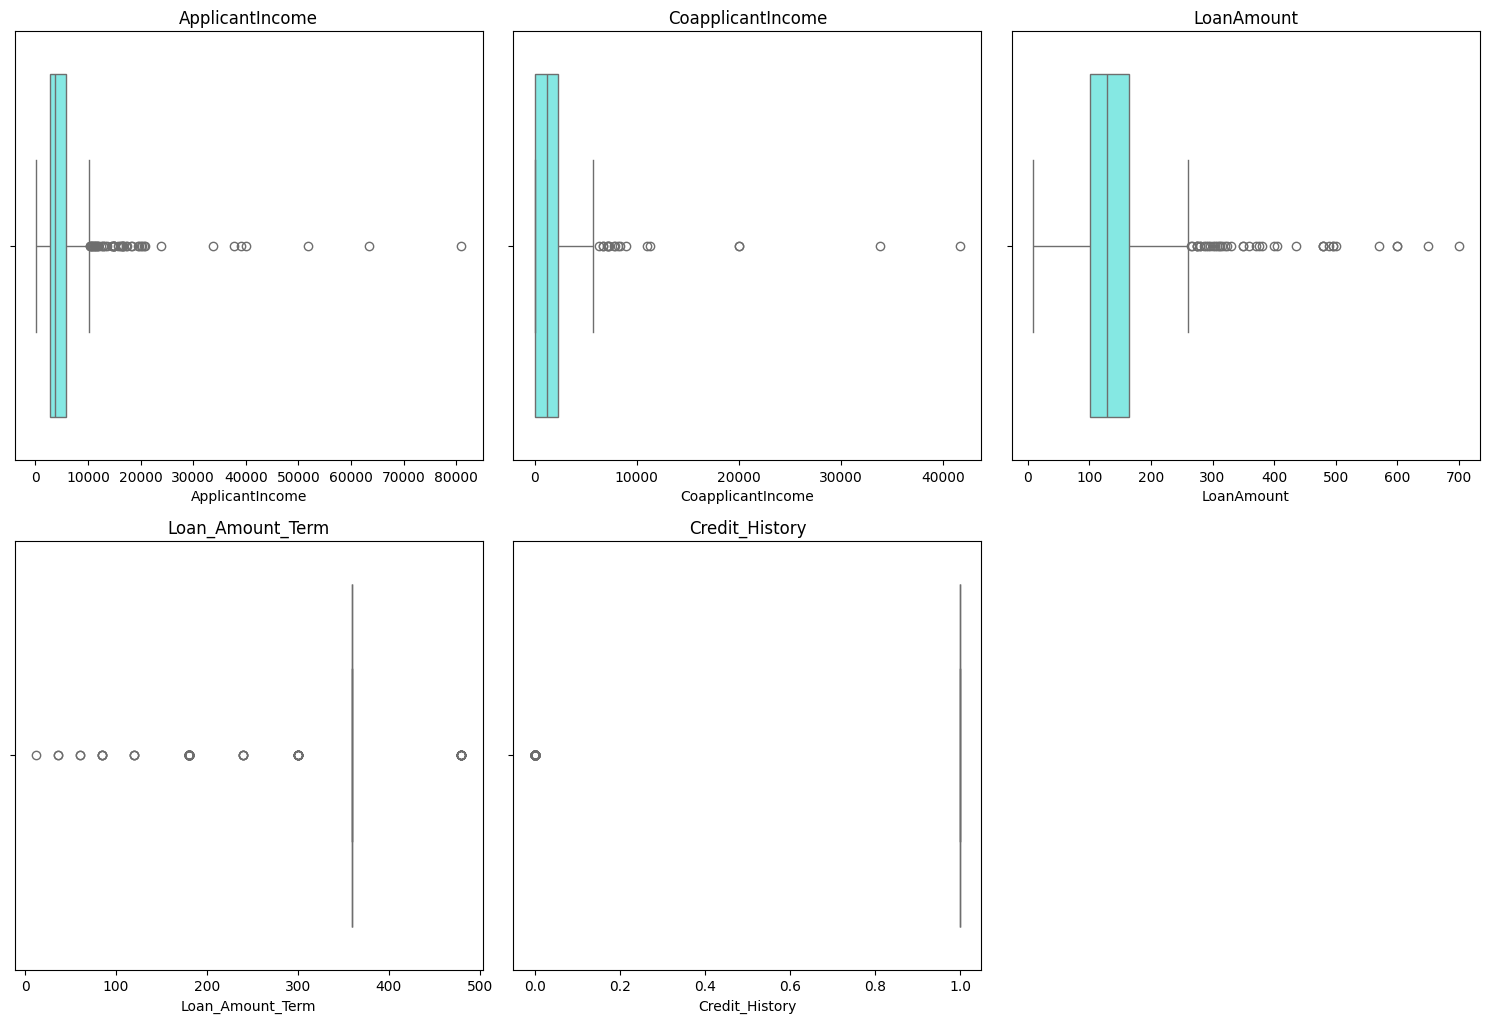

In [39]:
utils.estadisticas_descriptivas(df_train)
numeric_values = df_train.select_dtypes(include=['int64', 'float64'])
utils.plot_grafico_outliers(numeric_values,3,3,df_train)

Se ven variables con outliers presentes. Ademas, las estadísticas de las otras variables permanecieron prácticamente iguales, lo que indica que la imputación de LoanAmount no afectó significativamente otros datos.

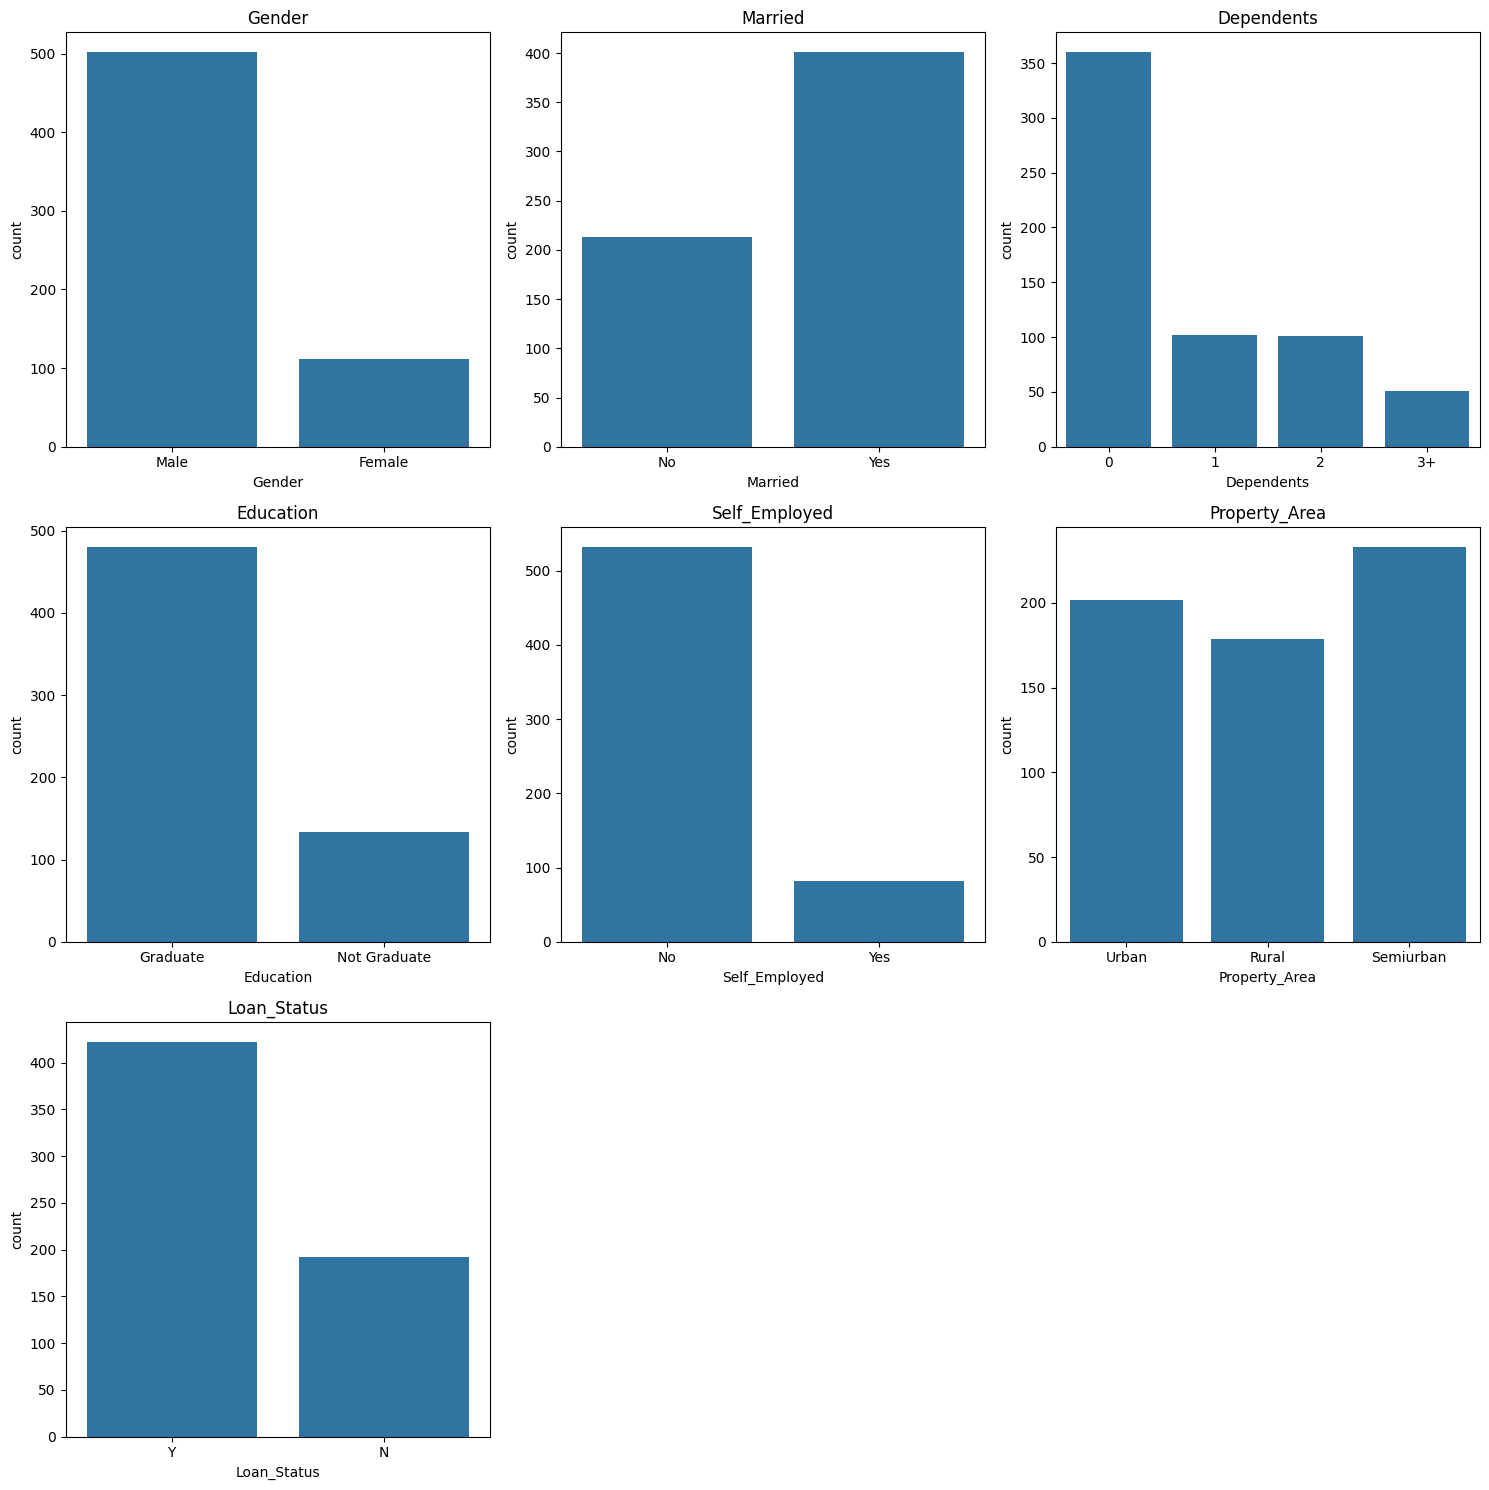

In [40]:

categ_variables = df_train.select_dtypes(include=['object'])
utils.plot_univariados_categoricos(categ_variables,3,3)

En los diferentes graficos se pueden observar las distribuciones de las variables categoricas donde se ven varibles dispersas para todas las variables categoricas, en especial nuestra target loan_status con mas Y que N.

Text(0, 0.5, 'LoanAmount')

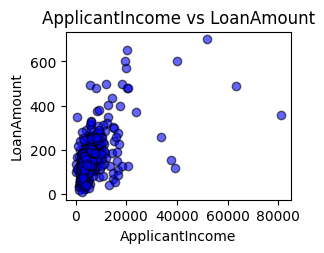

In [41]:
# Gráfico 1: ApplicantIncome vs LoanAmount
plt.subplot(2, 2, 1)
plt.scatter(df_train["ApplicantIncome"], df_train["LoanAmount"], alpha=0.6, c='blue', edgecolor='k')
plt.title("ApplicantIncome vs LoanAmount")
plt.xlabel("ApplicantIncome")
plt.ylabel("LoanAmount")


Aqui se puede ver que la gran mayoria de los applicantIncome se encuentran en el promedio de los 10000 y que estos normalmente solicitan el monto de entre 100 y 400, ademas se puede observar que los applicantIncome mayores solicitan un mayor loanAmount que es lo normal para su situacion

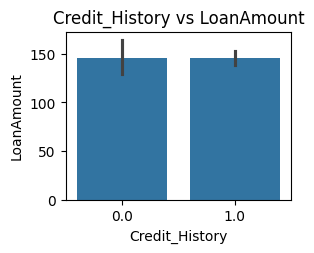

In [42]:
# Gráfico 4: Credit_History vs LoanAmount
plt.subplot(2, 2, 4)
sns.barplot(x="Credit_History", y="LoanAmount", data=df_train)  # ci=None para omitir intervalo de confianza
plt.title("Credit_History vs LoanAmount")
plt.xlabel("Credit_History")
plt.ylabel("LoanAmount")
plt.show()




En este grafico se ven que el loanAmount es igualmente distribuido entre los que tienen en regla sus credit_history.

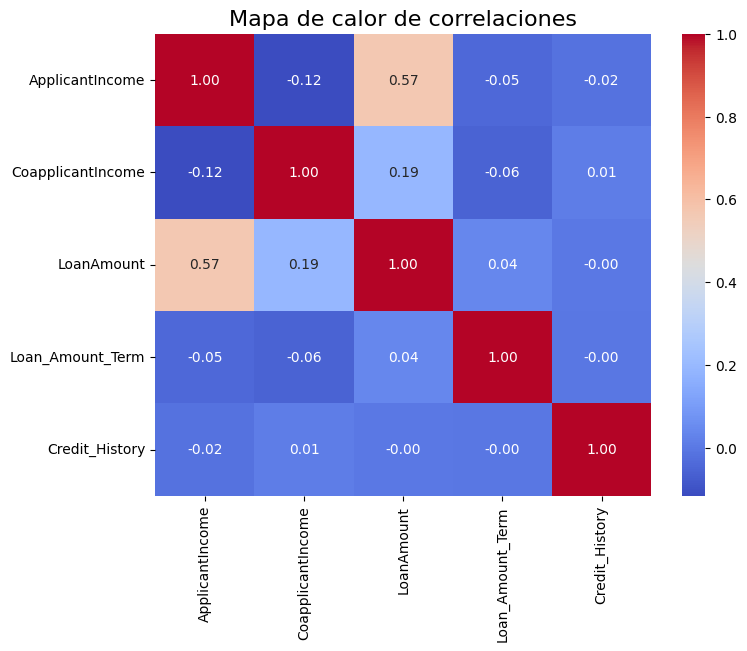

In [43]:
# Crear un mapa de calor para visualizar correlaciones
plt.figure(figsize=(8, 6))
correlation_matrix = numeric_values.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de calor de correlaciones", fontsize=16)
plt.show()


In [ ]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df_train.drop(['Loan_Status'], axis=1)
y = df_train['Loan_Status']
##transformamos y con labelenconder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [45]:
### Ya se han tratado los valores nulos pero aun existen valores outliers que seran escalados con RobustScaler
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Get column names
# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Crear transformer para columnas categóricas con imputación
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar categorías
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


[LightGBM] [Info] Number of positive: 332, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676171 -> initscore=0.736231
[LightGBM] [Info] Start training from score 0.736231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

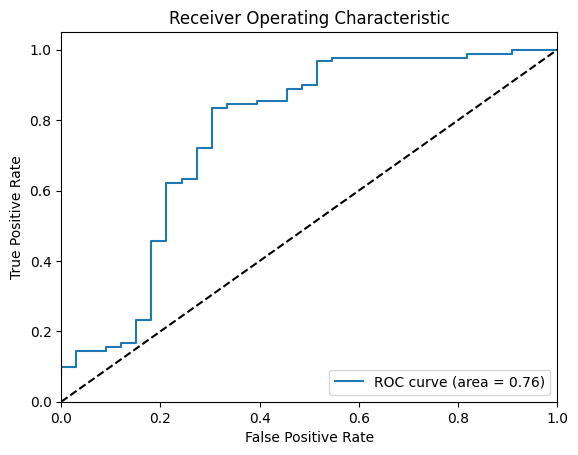

In [46]:
# Crear el modelo LightGBM
model = lgb.LGBMClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train_transformed, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_transformed)
y_prob = model.predict_proba(X_test_transformed)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Number of positive: 332, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676171 -> initscore=0.736231
[LightGBM] [Info] Start training from score 0.736231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

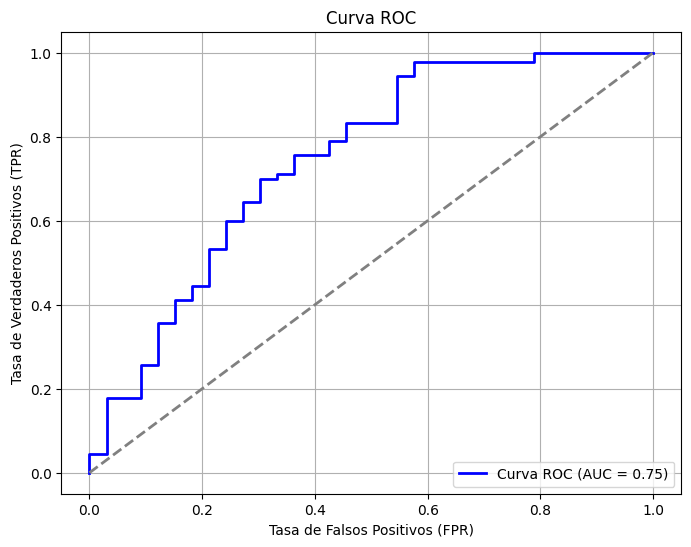

AUC: 0.75


In [54]:
# Definir el modelo base
lgbm = lgb.LGBMClassifier(random_state=42)

# Definir los parámetros para el GridSearch
param_grid = {
    'num_leaves': [31, 63],             # Número de hojas en los árboles
    'max_depth': [5, 10],              # Profundidad máxima del árbol (-1 significa ilimitado)
    'learning_rate': [0.01, 0.05],    # Tasa de aprendizaje
    'n_estimators': [100, 200],       # Número de árboles
    'min_child_samples': [10, 20],     # Mínimo de muestras por hoja
    'subsample': [0.8, 1.0]                # Submuestreo de filas
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',           # Usar F1-score para evaluar modelos
    cv=5,                   # Validación cruzada de 5 pliegues
    verbose=1,              # Mostrar progreso
    n_jobs=-1               # Usar todos los núcleos disponibles
)

# Entrenar el GridSearch en el conjunto de entrenamiento
grid_search.fit(X_train_transformed, y_train)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Exactitud:", accuracy_score(y_test, y_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Obtener las probabilidades predichas para la clase positiva (1)
y_prob = best_model.predict_proba(X_test_transformed)[:, 1]

# Calcular la curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.2f}")